In [1]:
from astropy.io import fits
import numpy as np
import glob
import os
from astropy.modeling import models, fitting, functional_models
import matplotlib.pyplot as plt

In [11]:
from google.colab import drive
drive.mount('/content/drive')
colab_datadir = f'/content/drive/Shareddrives/Follette-Lab-AWS/GAPlanetS_Database/'
os.chdir(colab_datadir)

In [2]:
def addstarpeak(dir, debug=False, verbose=False, mask=False, ghost=True, wl='Line', filelist=True):
    """
    fits star (or ghost) and adds STARPEAK to header. needed for PyKLIP.
    :param dir: directory
    :param amp: amplitude guess
    :param fwhm: fwhm
    :param debug: will print comparison of peak pixel values to fit values if set
    :param mask: will mask NaNs with zeros for fitting if set
    :param ghost: will fit ghost in lieu of star and return ghost peak and estimate for star peak in header.
    :param wl: set if ghost is set so it knows which scale factor to pull. values are "Line" or "Cont"
    :return: list of star (or ghost) peaks
    """
    if filelist:
      filelist = glob.glob(dir + '/*.fits')
      ##sort sequentially
      filelist.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
      n = len(filelist)
      dummy_im, head = fits.getdata(filelist[0], header=True)
    else:
      cube, head = fits.getdata(dir, header=True)
      dummy_im = cube[0] 
      n = cube.shape[0]
    size = dummy_im.shape
    xcen = int((size[0] - 1) / 2)
    ycen = int((size[1] - 1) / 2)
    # guesses for fit parameters. used as starting point
    # input_parameters = [0, amp, xcen, ycen, fwhm, fwhm, 0]
    if ghost == True:
        gxcen = int(xcen + 157.5)
        gycen = int(ycen - 7)
#         if wl == "Line":
#             ghost_scale = 184.7
#         if wl == "Cont":
#             ghost_scale = 193.6
#         if wl == "False":
#             "wl keyword must be set for ghost calibration"
#             return
    diff = np.zeros(n)
    peaks = []
    fwhmlist = []
    if ghost:
        gpeaks = []
        gfwhmlist = []
    #size of image stamp
    width = 31
    stmpsz = int((width - 1) / 2)

    for i in np.arange(n):
        if filelist:
          im = fits.getdata(filelist[i])
        else:
          im = cube[i]
        # make a copy - only invoked in case of ghost=True, but can't think of a cleverer way
        imcopy = np.copy(im)
        # head = fits.getheader(filelist[i])
        #crop around star (or ghost) for fitting
        imcopy = imcopy[ycen - stmpsz-1:ycen + stmpsz, xcen - stmpsz-1:xcen + stmpsz]

        #set up fit
        y,x = np.mgrid[:width,:width]
        #Moffat PSF model
        g_init=models.Moffat2D(np.nanmax(imcopy), stmpsz, stmpsz, 6, 1)
        fit_g=fitting.LevMarLSQFitter()

        # do fit
        p=fit_g(g_init,x,y,imcopy)
        
        if ghost:
            gimcopy = np.copy(im)
            gimcopy = gimcopy[gycen - stmpsz-1:gycen + stmpsz, gxcen - stmpsz-1:gxcen + stmpsz]
            gy, gx = np.mgrid[:width,:width]
            gg_init=models.Moffat2D(np.nanmax(gimcopy), stmpsz, stmpsz, 6, 1)
            gp = fit_g(gg_init,gx,gy,gimcopy)

        # populate headers for each individual image
        # if ghost == True:
        #     head['GSTPEAK'] = gp.amplitude.value
        #     head['STARPEAK'] = p.amplitude.value
        #     head['GSTFWHM'] = str(gp.fwhm)
        #     head['FWHM'] = str(p.fwhm)            
    
        # else:
        #     head['STARPEAK'] = p.amplitude.value
        #     head['FWHM'] = str(p.fwhm)

        # record peak
        if p.amplitude.value < 16000:
          peaks.append(p.amplitude.value)
        else:
          peaks.append(np.nan)
        # record fwhm
        fwhmlist.append(p.fwhm)
        if ghost:
            gpeaks.append(gp.amplitude.value)
            gfwhmlist.append(gp.fwhm)

        # print a warning if any peak values are unphysical
        if verbose:
            if (p.amplitude.value < 0) or (p.amplitude.value > 16000) or (np.isnan(p.amplitude.value)) == True:
                print("warning: unphysical peak value of", p.amplitude.value, 'for image', i + 1)

        # write out file with peak info in header
#         if ghost == True:
#             fits.writeto(filelist[i], im, header=head, overwrite=True)
#         else:
#             fits.writeto(filelist[i], im, header=head, overwrite=True)

        if debug == True:
            # print(filelist[i])
            # print('fit peak is:', p[0], '. max pixel is: ', np.nanmax(im[cen-10:cen+10,cen-10:cen+10]))
            imsz = im.shape[1]
            imcen = int((imsz - 1) / 2.)
            diff[i] = p.amplitude.value - np.nanmax(im[imcen - 10:imcen + 10, imcen - 10:imcen + 10])

    # write out list of peaks one directory up so KLIP doesn't try to pull it
    # if ghost == True:
    #     fits.writeto(dir + '../' + str(wl) + 'ghostpeaks.fits', np.array(peaks), overwrite=True)
    #     fits.writeto(dir + '../' + str(wl) + 'fwhmlist.fits', np.array(fwhmlist), overwrite=True)
    # else:
    #     fits.writeto(dir + '../' + str(wl) + 'starpeaks.fits', np.array(peaks), overwrite=True)
    #     fits.writeto(dir + '../' + str(wl) + 'fwhmlist.fits', np.array(fwhmlist), overwrite=True)

    if debug == True:
        print('standard deviation of difference between fit peak and max pixel is: ', np.std(diff))
        print('max difference is:', np.max(abs(diff)))
        print('median difference is:', np.median(diff))
    return n, np.array(peaks), np.array(fwhmlist), np.array(gpeaks), np.array(gfwhmlist)

In [72]:
n, peaks, fwhmlist, gpeaks, gfwhmlist = addstarpeak(os.getcwd()+'/HD142527/8Apr14_short/preprocessed/Line_clip451_flat_reg_nocosmics.fits', filelist=False)

1736 1736


In [3]:
import pandas as pd
prev_table = pd.read_csv('2019_ghost_calibration.csv', nrows=13)
prev_table

,Object Name,Date,Number of closed loop science Images,FWHM for registration,Saturated? (~1600+),FWHM (G if ghost),FWHM,Center x,Center y,Object counts,...,Center x.3,Center y.3,x offset.1,y offset.1,r.1,Object counts.3,"RP ""By eye"" Peak.3",good ghost photometry?.1,star/ghost peak ratio.1,star/ghost flux ratio.1
0,HD 100546,5/30/15,2459,6.9,N,6.32,6.32,225.1,225.1,1140000.0,...,382.1,218.3,157.0,-6.8,157.1,4131.62,44.0,Y,181.82,173.76
1,HD 142527,4/11/13,1961,4.3,N,4.00,4.00,225.0,225.0,282080.0,...,383.6,215.8,158.6,-9.2,158.9,1719.59,54.5,Y,222.02,190.04
2,HD 142527,4/8/14,1758,5.6,N,5.50,5.50,224.9,225.1,568561.0,...,383.0,217.0,158.1,-8.1,158.3,2507.01,50.0,Y,238.00,202.02
3,HD 142527,5/15/15,2387,5.2,N,5.01,5.01,225.0,225.0,488362.0,...,382.0,219.0,157.0,-6.0,157.1,2161.73,46.5,Y,247.31,198.48
4,HD 142527,2/10/17,242,5.8,N,5.50,5.50,225.0,225.1,761541.0,...,384.0,215.0,159.0,-10.2,159.3,3276.67,62.0,Y,190.32,197.07
5,HD 169142,4/8/14,2796,5.2,N,5.01,5.01,225.0,225.1,398046.0,...,383.0,216.0,158.0,-9.1,158.3,2063.67,45.0,Y,234.44,196.31
6,HD 169142,8/30/17,1658,6.4,N,6.17,6.17,224.9,225.1,710208.0,...,383.7,217.2,158.8,-7.9,159.0,3595.87,39.5,Y,200.00,179.89
7,PDS66,2/7/17,243,6.9,N,6.74,6.74,224.9,225.1,431572.0,...,383.7,218.1,NaN,NaN,NaN,1171.58,17.0,N,NaN,NaN
8,PDS70,2/8/17,188,8.7,N,8.36,8.36,349.9,350.0,899483.0,...,508.2,342.8,NaN,NaN,NaN,3476.71,26.0,N,NaN,NaN
9,TWHya,2/7/17,452,8.3,N,7.98,7.98,224.9,225.1,1580000.0,...,383.2,218.0,NaN,NaN,NaN,1428.93,11.5,N,NaN,NaN


In [15]:
monthdict = {"2":"Feb", "3":"Mar", "4":"Apr", "5":"May", "8":"Aug", "11":"Nov", "12":"Dec"}

In [ ]:
ns = []
peaklists = []
fwhmlists = []
gpeaklists = []
gfwhmlists = []

for i in prev_table.index:
  obj = prev_table["Object Name"][i].replace(' ', '')
  date = prev_table["Date"][i].split('/')
  month = monthdict[date[0]]
  night = date[1]
  year = date[2]
  path = obj+'/'+night+month+year
  if path == "HD142527/8Apr14":
    path = "HD142527/8Apr14_short"
  path = os.getcwd()+'/'+path+'/preprocessed/Cont_clip451_flat_reg_nocosmics.fits'
  if not os.path.exists(path):
    # print(path)
    if path == "/content/drive/Shareddrives/Follette-Lab-AWS/GAPlanetS_Database/HD142527/11Apr13/preprocessed/Cont_clip451_flat_reg_nocosmics.fits":
      path = "/content/drive/Shareddrives/Follette-Lab-AWS/GAPlanetS_Database/HD142527/11Apr13/preprocessed/Cont_clip451_reg_nocosmics.fits"
    elif path == "/content/drive/Shareddrives/Follette-Lab-AWS/GAPlanetS_Database/PDS70/8Feb17/preprocessed/Cont_clip451_flat_reg_nocosmics.fits":
      path = "/content/drive/Shareddrives/Follette-Lab-AWS/GAPlanetS_Database/PDS70/8Feb17/preprocessed/Cont_clip701_flat_reg_nocosmics.fits"
    else:
      break
  # if os.path.exists(path):
  #   print(path)
  n, peaklist, fwhmlist, gpeaklist, gfwhmlist = addstarpeak(path, filelist=False)
  ns.append(n)
  peaklists.append(peaklist)
  fwhmlists.append(fwhmlist)
  gpeaklists.append(gpeaklist)
  gfwhmlists.append(gfwhmlist)

# os.getcwd()+'/HD142527/8Apr14_short/preprocessed/Line_clip451_flat_reg_nocosmics.fits'

In [ ]:
moffits = np.array([ns, peaklists, fwhmlists, gpeaklists, gfwhmlists], dtype=object)
with open('ghostInventory_moffits_wnans.npy', 'wb') as f:
  np.save(f, moffits)

In [4]:
with open(os.getcwd()+'/ghostInventory_moffits_wnans.npy', 'rb') as f:
  moffits = np.load(f, allow_pickle=True)

c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

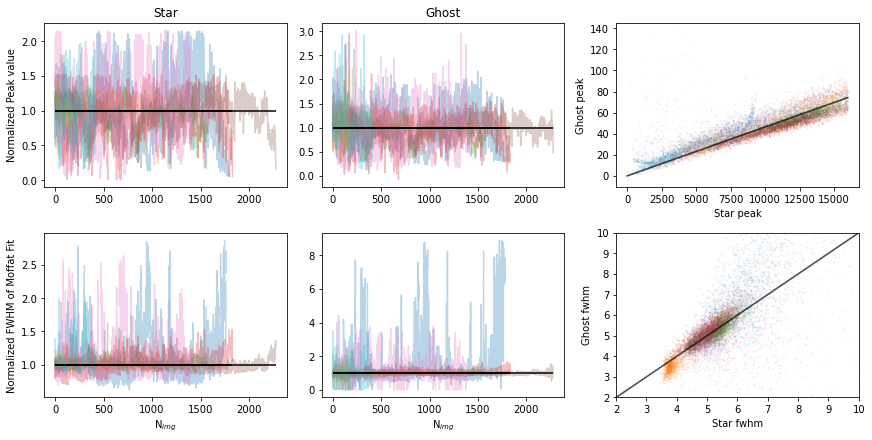

In [25]:
from astropy.stats import sigma_clip
# plotting relative to median
fig = plt.figure(constrained_layout=True, figsize=(12,6))
ax_dict = fig.subplot_mosaic(
    [
        ["starpeak", "ghostpeak", "peakscatter"],
        ["starfwhm", "ghostfwhm", "fwhmscatter"],
    ],
)

ax_dict["starpeak"].set_title("Star")
ax_dict["ghostpeak"].set_title("Ghost")
ax_dict["starfwhm"].set_xlabel(r"N$_{img}$")
ax_dict["ghostfwhm"].set_xlabel(r"N$_{img}$")
ax_dict["starpeak"].set_ylabel("Normalized Peak value")
ax_dict["starfwhm"].set_ylabel("Normalized FWHM of Moffat Fit")

for i in range(moffits.shape[1]):#[1:]:
  moffit = moffits[:,i]
  n, peaklist, fwhmlist, gpeaklist, gfwhmlist = moffit
  # print(n)

  mofarr = np.zeros((n,4))
  mofarr[:,0] = peaklist
  mofarr[:,1] = fwhmlist
  mofarr[:,2] = gpeaklist
  mofarr[:,3] = gfwhmlist
  mofarr = mofarr[~np.isnan(mofarr).any(axis=1)]
  n = mofarr.shape[0]

  # peaklist, fwhmlist, gpeaklist, gfwhmlist

  # sigma clip to remove failed fits
  peaklist = sigma_clip(mofarr[:,0], sigma=5)
  fwhmlist = sigma_clip(mofarr[:,1], sigma=5)
  gpeaklist = sigma_clip(mofarr[:,2], sigma=5)
  gfwhmlist = sigma_clip(mofarr[:,3], sigma=5)

  x = np.linspace(1,n+1, num=n)

  # some calcs
  peakmed = np.nanmedian(peaklist)
  peakstd = np.std(peaklist)
  gpeakmed = np.nanmedian(gpeaklist)
  gpeakstd = np.std(gpeaklist)

  fwhmmed = np.nanmedian(fwhmlist)
  fwhmstd = np.std(fwhmlist)
  gfwhmmed = np.nanmedian(gfwhmlist)
  fwhmstd = np.std(gfwhmlist)

  ax_dict["starpeak"].plot(x, peaklist/peakmed, alpha=0.3)
  ax_dict["starpeak"].hlines(1, x.min(), x.max(), 'k', zorder=3)
  ax_dict["ghostpeak"].plot(x, gpeaklist/gpeakmed, alpha=0.3)
  ax_dict["ghostpeak"].hlines(1, x.min(), x.max(), 'k', zorder=3)

  ax_dict["starfwhm"].plot(x, fwhmlist/fwhmmed, alpha=0.3)
  ax_dict["starfwhm"].hlines(1, x.min(), x.max(), 'k', zorder=3)
  ax_dict["ghostfwhm"].plot(x, gfwhmlist/gfwhmmed, alpha=0.3)
  ax_dict["ghostfwhm"].hlines(1, x.min(), x.max(), 'k', zorder=3)

  ax_dict["peakscatter"].scatter(x=peaklist, y=gpeaklist, label=str(n), alpha=0.1, s=0.5)
  ax_dict["peakscatter"].set_xlabel("Star peak")
  ax_dict["peakscatter"].set_ylabel("Ghost peak")
#   ax_dict["fwhmscatter"].set_xlim(2,10)
#   ax_dict["fwhmscatter"].set_ylim(2,10)
# 215.56
# 22.32
  ax_dict["peakscatter"].plot(np.arange(0,16000), np.arange(0,16000)/215.56, alpha=0.1, color='k', zorder=10)
#   ax_dict["peakscatter"].fill_between(np.arange(0,16000), (np.arange(0,16000)/215.56)-22.32, y2=(np.arange(0,16000)/215.56)+22.32, alpha=0.01)
  ax_dict["fwhmscatter"].scatter(x=fwhmlist, y=gfwhmlist, label=str(n), alpha=0.1, s=0.5)
  ax_dict["fwhmscatter"].set_xlabel("Star fwhm")
  ax_dict["fwhmscatter"].set_ylabel("Ghost fwhm")
  ax_dict["fwhmscatter"].set_xlim(2,10)
  ax_dict["fwhmscatter"].set_ylim(2,10)
  ax_dict["fwhmscatter"].plot(np.arange(0,11),np.arange(0,11), alpha=0.1, color='k')

plt.savefig('ghostInvestigation_all.png',dpi=300)

2430


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


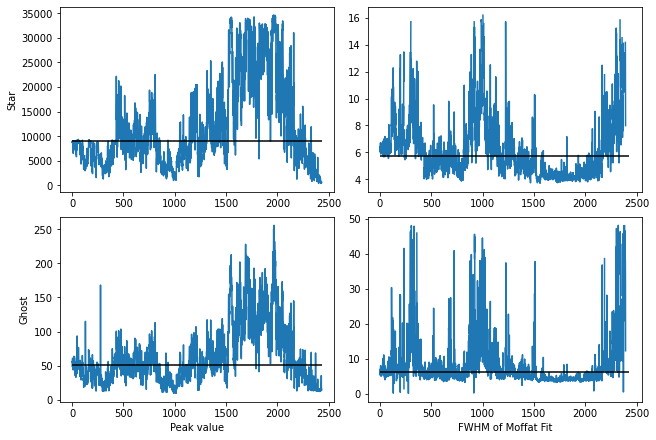

1446


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


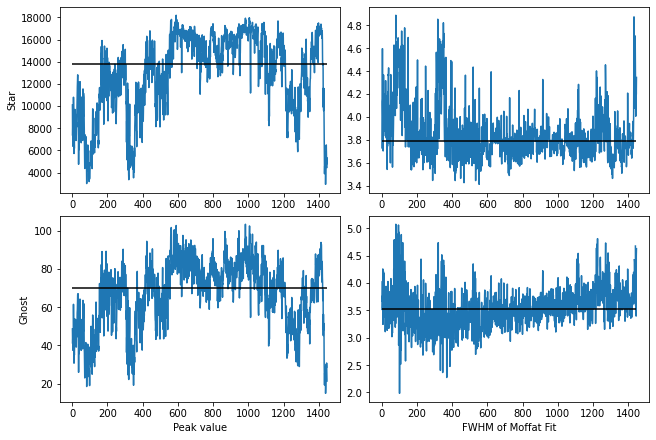

1569


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


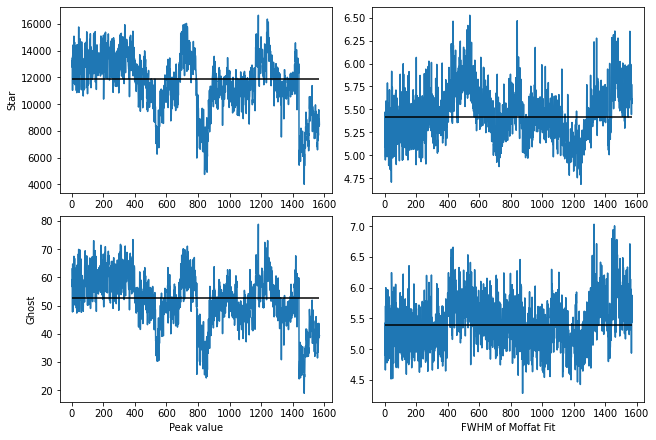

2367


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


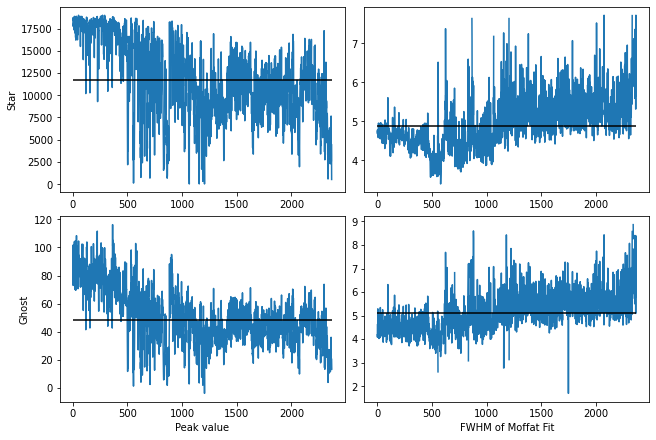

201


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


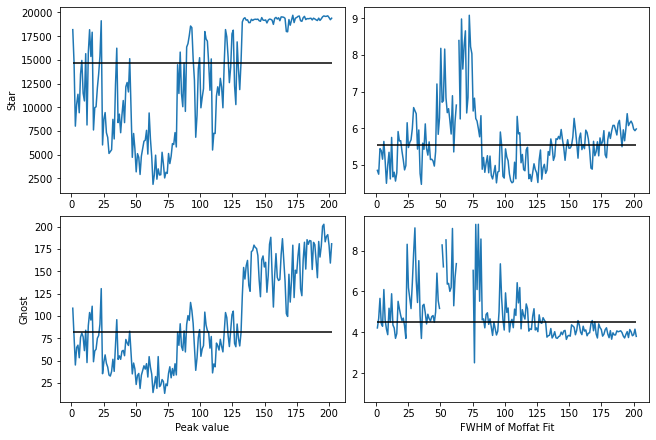

2392


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


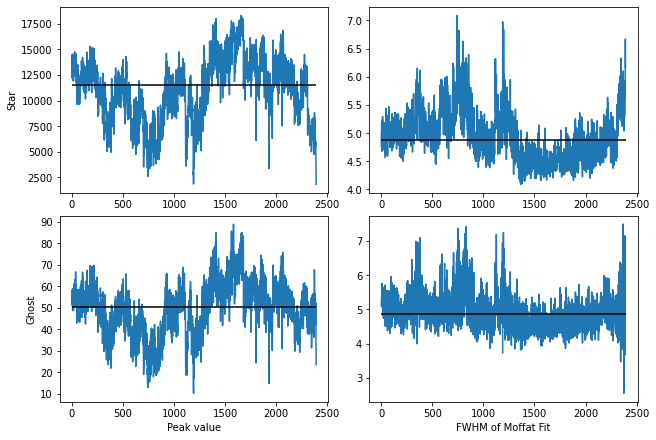

1643


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


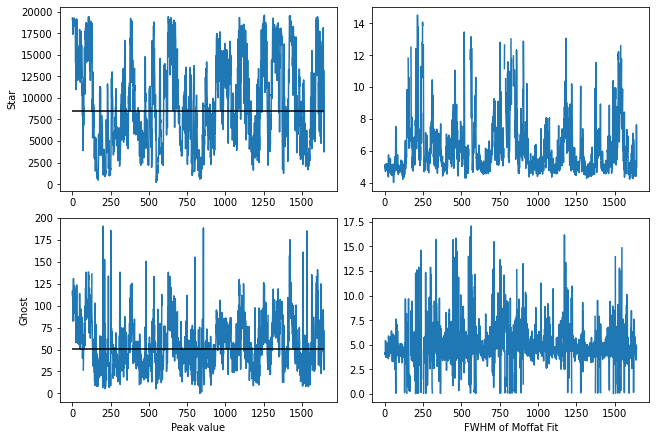

232


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


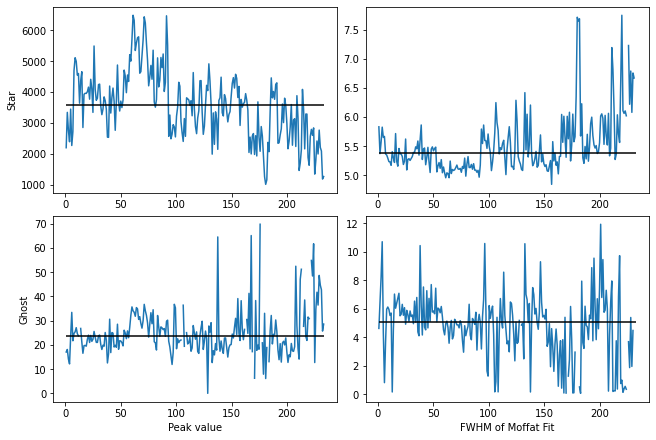

174


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


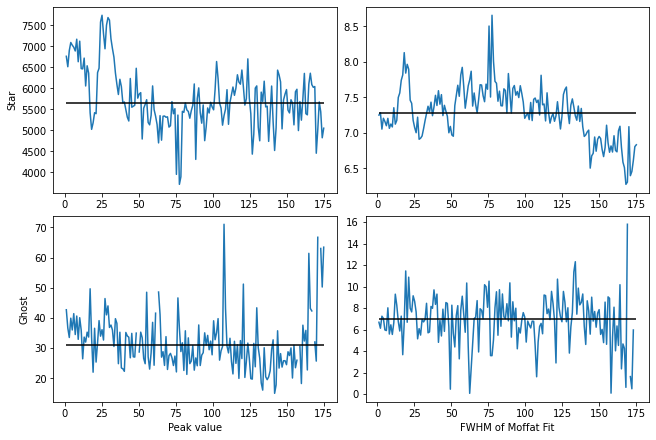

414


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


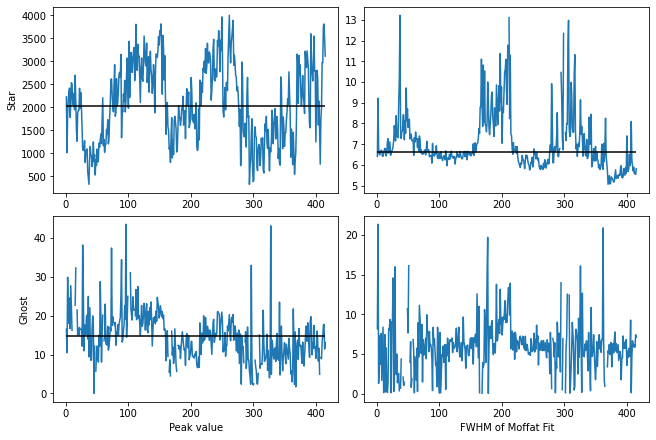

In [67]:
for i in range(moffits.shape[1]):
  moffit = moffits[:,i]
  n, peaklist, fwhmlist, gpeaklist, gfwhmlist = moffit
  print(n)

  # sigma clip to remove failed fits
  peaklist = sigma_clip(peaklist, sigma=5)
  fwhmlist = sigma_clip(fwhmlist, sigma=5)
  gpeaklist = sigma_clip(gpeaklist, sigma=5)
  gfwhmlist = sigma_clip(gfwhmlist, sigma=5)

  # plotting to show values
  fig = plt.figure(constrained_layout=True, figsize=(9,6))
  ax_dict = fig.subplot_mosaic(
      [
          ["starpeak", "starfwhm"],
          ["ghostpeak", "ghostfwhm"],
      ],
  )

  x = np.linspace(1,n+1, num=n)

  # some calcs
  peakmed = np.nanmedian(peaklist)
  peakstd = np.std(peaklist)
  gpeakmed = np.nanmedian(gpeaklist)
  gpeakstd = np.std(gpeaklist)

  fwhmmed = np.nanmedian(fwhmlist)
  fwhmstd = np.std(fwhmlist)
  gfwhmmed = np.nanmedian(gfwhmlist)
  fwhmstd = np.std(gfwhmlist)

  ax_dict["starpeak"].set_ylabel("Star")
  ax_dict["ghostpeak"].set_ylabel("Ghost")
  ax_dict["ghostpeak"].set_xlabel("Peak value")
  ax_dict["ghostfwhm"].set_xlabel("FWHM of Moffat Fit")

  ax_dict["starpeak"].plot(x, peaklist)
  ax_dict["starpeak"].hlines(peakmed, x.min(), x.max(), 'k', zorder=3)
  ax_dict["ghostpeak"].plot(x, gpeaklist)
  ax_dict["ghostpeak"].hlines(gpeakmed, x.min(), x.max(), 'k', zorder=3)

  ax_dict["starfwhm"].plot(x, fwhmlist)
  ax_dict["starfwhm"].hlines(fwhmmed, x.min(), x.max(), 'k', zorder=3)
  ax_dict["ghostfwhm"].plot(x, gfwhmlist)
  ax_dict["ghostfwhm"].hlines(gfwhmmed, x.min(), x.max(), 'k', zorder=3)

  plt.show()

# plt.yscale('log')